In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
T = math.ceil(1500000 / 32)
k = 3

In [3]:
batch_size = 16

In [4]:
x = torch.rand(batch_size, 3)
y = torch.randint(k, (batch_size, ))

x_bce = torch.rand(batch_size, 1)
y_bce = torch.randint(2, (batch_size, 1)).float()

In [5]:
from tsa import TrainingSignalAnnealing, TSAScheduleCrossEntropy, TSAScheduleBinaryCrossEntropy

In [6]:
ce_tsa = TSAScheduleCrossEntropy(total_steps=T, n_classes=k)
bce_tsa = TSAScheduleBinaryCrossEntropy(total_steps=T, n_classes=2, current_step=T//3)

In [7]:
ce_tsa

TSAScheduleCrossEntropy(
  (activation_function): Softmax()
)

In [8]:
bce_tsa

TSAScheduleBinaryCrossEntropy(
  (activation_function): Sigmoid()
)

In [9]:
correct_x, correct_y = ce_tsa(x, y)

In [10]:
correct_x_bce, correct_y_bce = bce_tsa(x_bce, y_bce)

In [11]:
correct_x.shape, correct_y.shape

(torch.Size([9, 3]), torch.Size([9]))

In [12]:
correct_x_bce.shape, correct_y_bce.shape

(torch.Size([13, 1]), torch.Size([13, 1]))

In [13]:
ce = torch.nn.CrossEntropyLoss()
bce = torch.nn.BCELoss()

In [14]:
ce(x, y)

tensor(1.1317)

In [15]:
ce(correct_x, correct_y)

tensor(1.2833)

In [16]:
bce(x_bce, y_bce)

tensor(1.0390)

In [17]:
bce(correct_x_bce, correct_y_bce)

tensor(1.2536)

In [18]:
torch.nn.functional.cross_entropy(x, y, reduction='none').sum()

tensor(18.1071)

In [19]:
torch.nn.functional.cross_entropy(correct_x, correct_y, reduction='none').sum()

tensor(11.5494)

In [20]:
torch.nn.functional.cross_entropy(x, y, reduction='none').mean()

tensor(1.1317)

In [21]:
torch.nn.functional.cross_entropy(correct_x, correct_y, reduction='none').mean()

tensor(1.2833)

In [22]:
torch.nn.functional.binary_cross_entropy(x_bce, y_bce, reduction='none').sum()

tensor(16.6244)

In [23]:
torch.nn.functional.binary_cross_entropy(correct_x_bce, correct_y_bce, reduction='none').sum()

tensor(16.2963)

In [24]:
torch.nn.functional.cross_entropy(x, y, reduction='none').mean()

tensor(1.1317)

In [25]:
torch.nn.functional.cross_entropy(correct_x, correct_y, reduction='none').mean()

tensor(1.2833)

In [26]:
x_bce.shape, correct_x_bce.shape

(torch.Size([16, 1]), torch.Size([13, 1]))

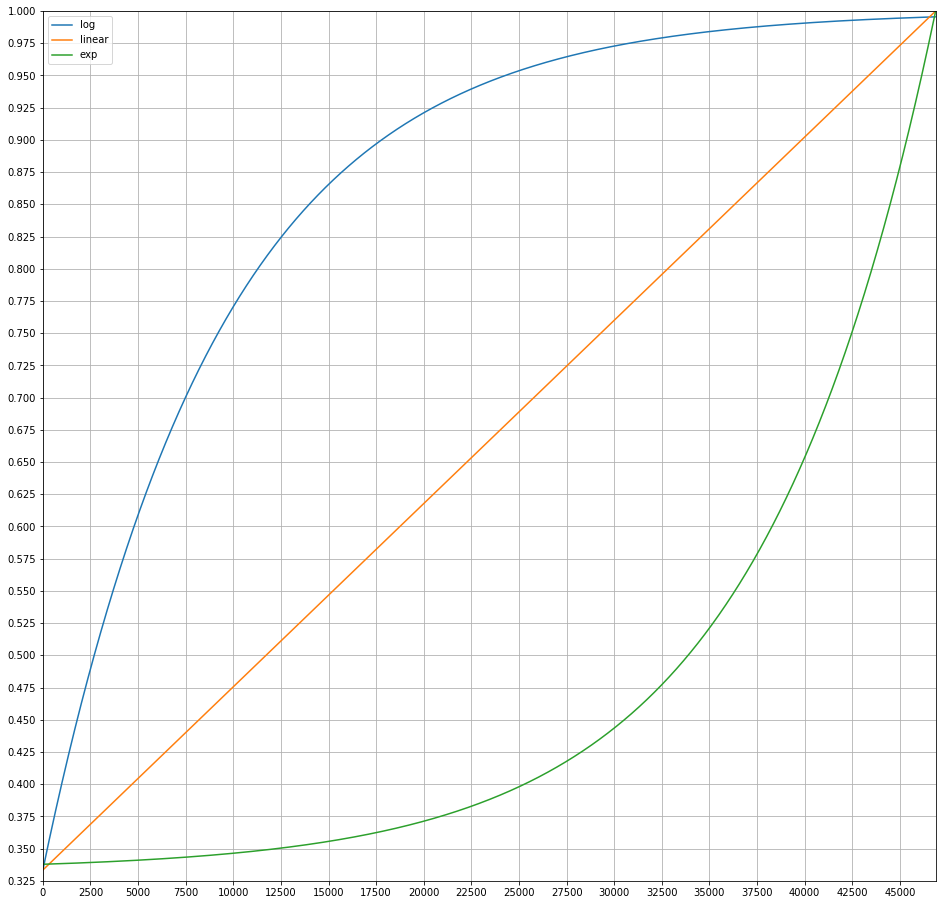

In [27]:
tsa_linear = TrainingSignalAnnealing(total_steps=T, n_classes=k)
tsa_log = TrainingSignalAnnealing(total_steps=T, n_classes=k, schedule_type='log')
tsa_exp = TrainingSignalAnnealing(total_steps=T, n_classes=k, schedule_type='exp')

plt.figure(figsize=(16, 16))
plt.plot([p for p in tsa_log], label='log')
plt.plot([p for p in tsa_linear], label='linear')
plt.plot([p for p in tsa_exp], label='exp')
plt.grid()
plt.xlim(0, T)
plt.ylim(1/k, 1)
plt.xticks(range(0, T, 2500))
plt.yticks(np.arange(0.325, 1.025, 0.025))
plt.legend()

In [28]:
bce_tsa.tsa.current_step

15626

In [29]:
bce_tsa.tsa.current_prob

0.6666773333333333

In [30]:
bce_tsa.tsa.update(10000)

0.7733333333333333

In [31]:
bce_tsa.tsa.current_prob

0.773344

In [32]:
bce_tsa.tsa.restart()

In [33]:
bce_tsa.tsa.current_prob

0.5

In [34]:
bce_tsa.tsa.current_step

0

In [35]:
c = torch.nn.BCELoss()

In [36]:
c == torch.nn.BCELoss()

False

In [37]:
c = torch.nn.BCELoss()
c == torch.nn.BCELoss()

False

In [38]:
ce_tsa.restart()

In [39]:
from sklearn.datasets import make_classification, make_blobs

In [40]:
x.shape

torch.Size([16, 3])

In [41]:
# plt.scatter(x[:25000, 0], x[:25000, 1], marker='o', c=y, s=25, edgecolor='k')

In [ ]:
from tqdm import tqdm

In [ ]:
N_EPOCHS = 5
N_SAMPLES = 100000
K_CLASSES = 3
N_STEPS = N_SAMPLES // batch_size

batch_size = 128

x, y = make_classification(n_samples=550000, n_classes=K_CLASSES, n_informative=5, n_features=300)

In [ ]:
x_train, x_test = x[:-50000], x[-50000:]
y_train, y_test = y[:-50000], y[-50000:]

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=300, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=3))

In [ ]:
tsa = TSAScheduleCrossEntropy(total_steps=N_EPOCHS * N_STEPS,
                              n_classes=K_CLASSES,
                              schedule_type='log')

In [ ]:
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for n_epoch in range(N_EPOCHS):

    pg = tqdm(total=N_STEPS, desc=f'Epoch: {n_epoch}')
    
    for i in range(N_STEPS):
        
        optimizer.zero_grad()

        x_batch = torch.Tensor(x_train[i:i + batch_size])
        y_batch = torch.Tensor(y_train[i:i + batch_size]).long()
        
        pred = net(x_batch)
        
        correct_pred, correct_y = tsa(pred, y_batch)
        
        if correct_pred.shape[0] == 0:
            continue
        
        loss = criterion(correct_pred, correct_y)
        
        loss.backward()
        optimizer.step()
        
        pg.update()
        
        pg.set_postfix(loss=loss.item())
        
pg.close()